# Project 03 - 3D reconstruction

__Handout date:__ 27.06.2024      
__Submission date:__ 18.07.2023 - 23:59
__Submission link:__ https://fz-juelich.sciebo.de/s/rVa2i83BrBmyaJ8


In this project, you will work on 3D reconstruction from stereo data.
You will estimate disparity maps from rectified images, and resolve inconsistencies in the results using graphical models.

For this task, you will use the [2014 Stereo Datasets](https://vision.middlebury.edu/stereo/data/scenes2014/).
The dataset contains rectified images and serves as a benchmark for depth estimation from stereo images.

1. Download the dataset and inspect its structure.
1. Choose at least two images from the dataset to work with. For the beginning, work with the default images (no variation in lightning or exposure).
1. Use the methods discussed in the lecture to compute the disparity between the two images, which involves:
    1. Scanline approach to identify matching pixels using an appropriate similarity metric.
    1. Cross-checking using reverse scanline.
    1. Resolution of ambiguous matches.
1. Use the computed disparity to estimate the depth.
1. Repeat the above steps using the provided images with varying lightning and exposure.
1. Use a Markov Random Field (MRF) to resolve holes and inaccuracies in the computed disparity maps.
    1. Install [gco-wrapper](https://github.com/Borda/pyGCO) using `pip install gco-wrapper`.
    1. Convert the task of smoothing the disparity map into a MRF problem. In particular, think about how labels can be defined for this task (tip: maximum disparity).
    1. Use `cut_grid_graph` or `cut_grid_graph_simple` to solve the defined MRF.
1. Recompute the depth map using your corrected disparity maps and compare them to the previous result. Repeat the analysis for your selected images under different lightning and exposure.

__Tip:__ Do not replicate your code, use functions to repeat the analysis on different image pairs.

In [4]:
pip install gco-wrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.0/243.0 kB 1.8 MB/s eta 0:00:00


In [5]:
# import packages
import skimage.io as io
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gco import cut_grid_graph_simple

/usr/local/lib/python3.10/dist-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


Reference:

https://www.baeldung.com/cs/disparity-map-stereo-vision#:~:text=Given%20a%20pair%20of%20stereo,values%20as%20an%20intensity%20image.

http://media.ee.ntu.edu.tw/courses/cv/21S/hw/hw4/hw4.pdf

Sum of Absolute Differences(SAD)

In [7]:
# 1~2. We work on images Bicycle1 and Classroom1
folders = np.array(['Bicycle1-perfect', 'Classroom1-perfect'])

# 3 compute disparity between the two images
def read_calib_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    calib = {}
    for line in lines:
        key, value = line.split('=')
        if key == 'cam0':
            calib['focal_length'] = float(value.replace('[','').split()[0])
        if key == 'baseline':
            calib['baseline'] = float(value)
    return calib

## The code was taken from rocketchat
def block_distance_map(
    img1: np.ndarray, img2: np.ndarray, block_size: int = 5, block_stride: int = 1
) -> np.ndarray:
    """Calculate the distance between the pixels of two images, using blocks."""
    dist = np.linalg.norm(
        img1.astype(np.float32) - img2.astype(np.float32), axis=-1  # type: ignore
    )
    blocks = _create_blocks(dist, block_size, block_stride)

    avg_dist = blocks.mean(axis=0)
    avg_dist = avg_dist.reshape(*img1.shape[:2])

    return avg_dist


def _create_blocks(image: np.ndarray, block_size: int, block_stride: int):
    steps = np.arange(-block_size // 2, 1 + block_size // 2)
    blocks = [
        np.roll(image, (y * block_stride, x * block_stride), axis=(0, 1))
        for y in steps
        for x in steps
    ]
    return np.stack(blocks, axis=0)

def calc_disparity_map(
    left_img: np.ndarray,
    right_img: np.ndarray,
    possible_disparities: np.ndarray | list[int],
    block_size: int = 5,
    block_stride: int = 1,
) -> np.ndarray:
    """Calculate the disparity map between two images."""

    # initialize the disparity map block with zeros
    disparity_map_block = np.zeros(
        (left_img.shape[0], left_img.shape[1], len(possible_disparities)),
        dtype=np.float32,
    )

    # iterate over the possible disparities
    for i, disparity in tqdm(list(enumerate(possible_disparities))):
        right_shifted = np.roll(right_img, disparity, axis=1)
        if disparity < 0:
            right_shifted[:, disparity:] = 0
        elif disparity > 0:
            right_shifted[:, :disparity] = 0
        disparity_map_block[:, :, i] = block_distance_map(
            left_img, right_shifted, block_size=block_size, block_stride=block_stride
        )

    # find the most possible disparities
    disparity_map = possible_disparities[np.argmin(disparity_map_block, axis=2)]

    return disparity_map

# Left-right consistency check
def left_right_consistency(disparity_map_left: np.ndarray, disparity_map_right: np.ndarray) -> np.ndarray:
    """Perform left-right consistency check."""
    check = np.zeros_like(disparity_map_left)
    for y in range(disparity_map_left.shape[0]):
        for x in range(disparity_map_left.shape[1]):
            if (x - disparity_map_left[y, x]) >= 0 and ((x - disparity_map_left[y, x]) < disparity_map_left.shape[1]):
                check[y, x] = abs(disparity_map_left[y, x] - disparity_map_right[y, x - disparity_map_left[y, x]])<1
    return check


# Compute the disparity and depth map
images = ['im1.png', 'im1E.png', 'im1L.png']
disparities = {}
depths = {}

for folder in folders:
    disparity = {}
    disparities[folder] = disparity
    depth = {}
    depths[folder] = depth
    calib = read_calib_file(folder + '/calib.txt')
    baseline = calib['baseline']
    focal_length = calib['focal_length']
    img1 = io.imread(folder + '/im0.png')
    disparity_limit = 16
    img1 = resize(img1, (img1.shape[0], img1.shape[1]))

    for right in images:
        img2 = io.imread(folder + '/' + right)
        img2 = resize(img2, (img2.shape[0], img2.shape[1]))

        disparity_map_left = calc_disparity_map(img1, img2, np.arange(-disparity_limit, disparity_limit))
        disparity_map_right = calc_disparity_map(img2, img1, np.arange(-disparity_limit, disparity_limit))

        disparity_map = np.where(left_right_consistency(disparity_map_left, disparity_map_right), disparity_map_left, 0)

        disparity[right +'_disparity_map'] = disparity_map
        disparity[right + '_disparity_map_left'] = disparity_map_left
        disparity[right + '_disparity_map_right'] = disparity_map_right

        # 4. Compute the depth map
        depth_map = focal_length * baseline / disparity_map_left
        depth[right + '_depth_map'] = depth_map


100%|██████████| 32/32 [00:55<00:00,  1.74s/it]
<ipython-input-7-630a9e1a5f96>:115: RuntimeWarning: divide by zero encountered in divide
  depth_map = focal_length * baseline / disparity_map_left
100%|██████████| 32/32 [00:55<00:00,  1.73s/it]


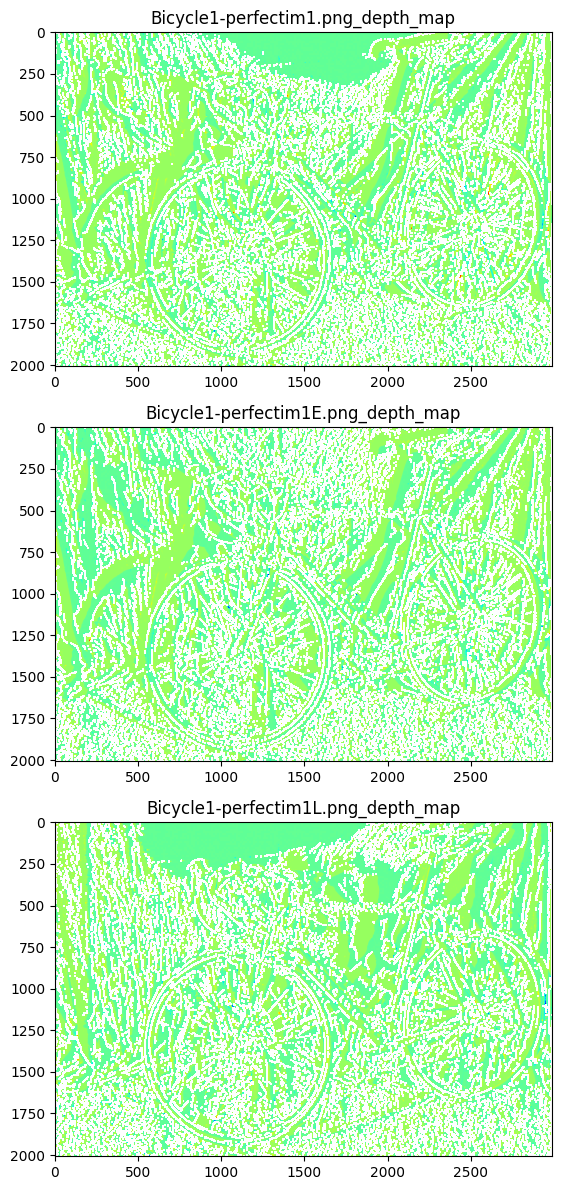

In [24]:
depth_list = [i + '_depth_map' for i in images]

plt.figure(figsize=(10,12), layout="tight")
for j in range(len(depth_list)):
  plt.subplot(3, 1, j+1)
  plt.gca().set_title("{}".format(folders[0]+depth_list[j]))
  plt.imshow(depths[folders[0]][depth_list[j]], cmap='jet')
plt.show()

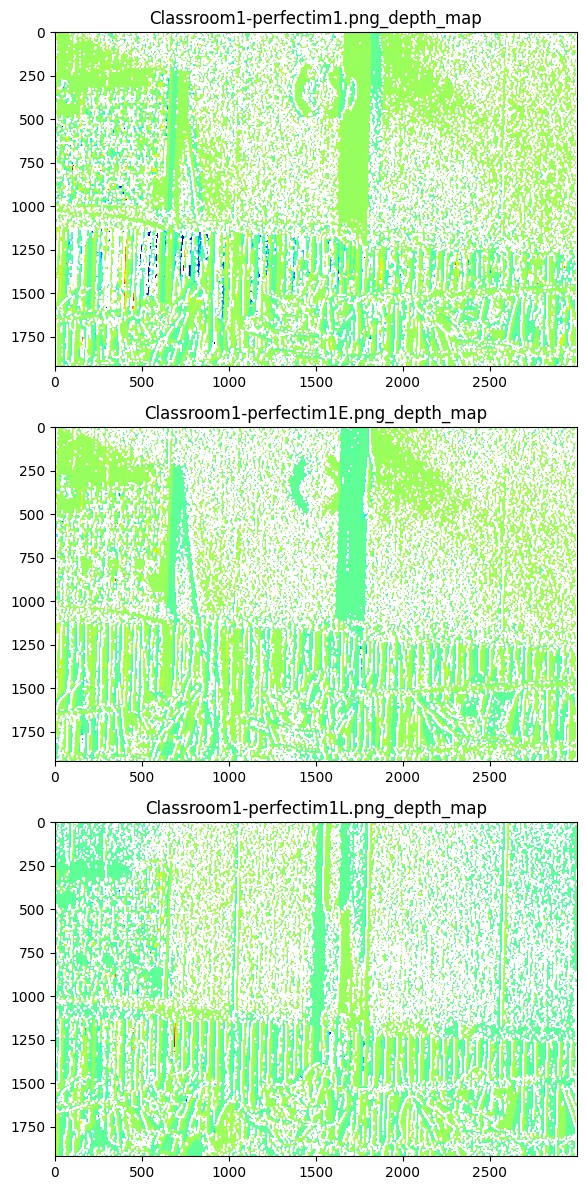

In [25]:
plt.figure(figsize=(10,12), layout="tight")
for j in range(len(depth_list)):
  plt.subplot(3, 1, j+1)
  plt.gca().set_title("{}".format(folders[1]+depth_list[j]))
  plt.imshow(depths[folders[1]][depth_list[j]], cmap='jet')
plt.show()

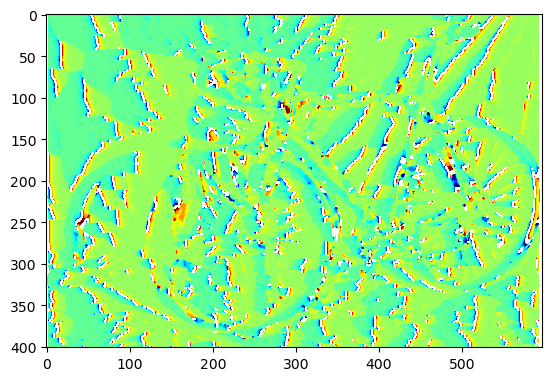

In [ ]:
depth = depths['Bicycle1-perfect']['im1E.png_depth_map']
plt.imshow(depth, cmap='jet')

In [ ]:
# 6.1 Install gco-wrapper
!pip install gco-wrapper

Reference:

https://courses.grainger.illinois.edu/cs543/sp2017/lectures/Lecture%2019%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2017.pdf

In [26]:
def markov_random_fields(disparity_map):
    # unary term
    n = np.unique(disparity_map).shape[0]
    unary = np.tile(disparity_map[:,:,np.newaxis], (1, 1, n))
    for i in np.unique(disparity_map):
        unary[:, :, i] = (disparity_map == i)*1

    # pairwise term: activate when the disparity is different
    smooth = 1 - np.eye(n)
    labels = cut_grid_graph_simple(unary, smooth*0.0, n_iter=-1)
    return labels

In [38]:
# compute disparity maps by mrf
labels = {}
for folder in folders:
  label = {}
  labels[folder] = label
  for img in images:
    labels[folder][img+'_disparity_map_left'] = markov_random_fields(disparities[folder][img+'_disparity_map_left']).reshape(disparities[folder][img+'_disparity_map'].shape)

In [42]:
# compute the depth maps from corrected disparity maps
depths_c = {}
for folder in folders:
  depth_c = {}
  depths_c[folder] = depth_c
  for img in images:
    depth_map = focal_length * baseline / labels[folder][img+'_disparity_map_left']
    depth_c[img + '_depth_map'] = depth_map

<ipython-input-42-373f69248227>:7: RuntimeWarning: divide by zero encountered in divide
  depth_map = focal_length * baseline / labels[folder][img+'_disparity_map_left']


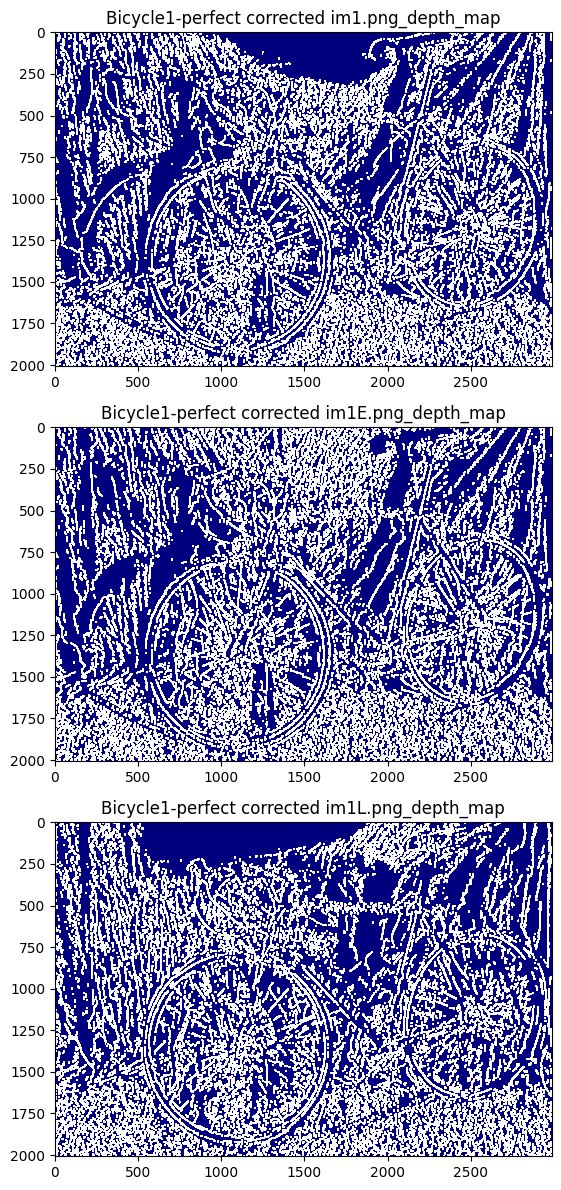

In [44]:
# plot corrected depth maps of bicycle1-perfect
depth_c_list = [i + '_depth_map' for i in images]

plt.figure(figsize=(10,12), layout="tight")
for j in range(len(depth_c_list)):
  plt.subplot(3, 1, j+1)
  plt.gca().set_title("{}".format(folders[0]+' corrected '+depth_c_list[j]))
  plt.imshow(depths_c[folders[0]][depth_c_list[j]], cmap='jet')
plt.show()

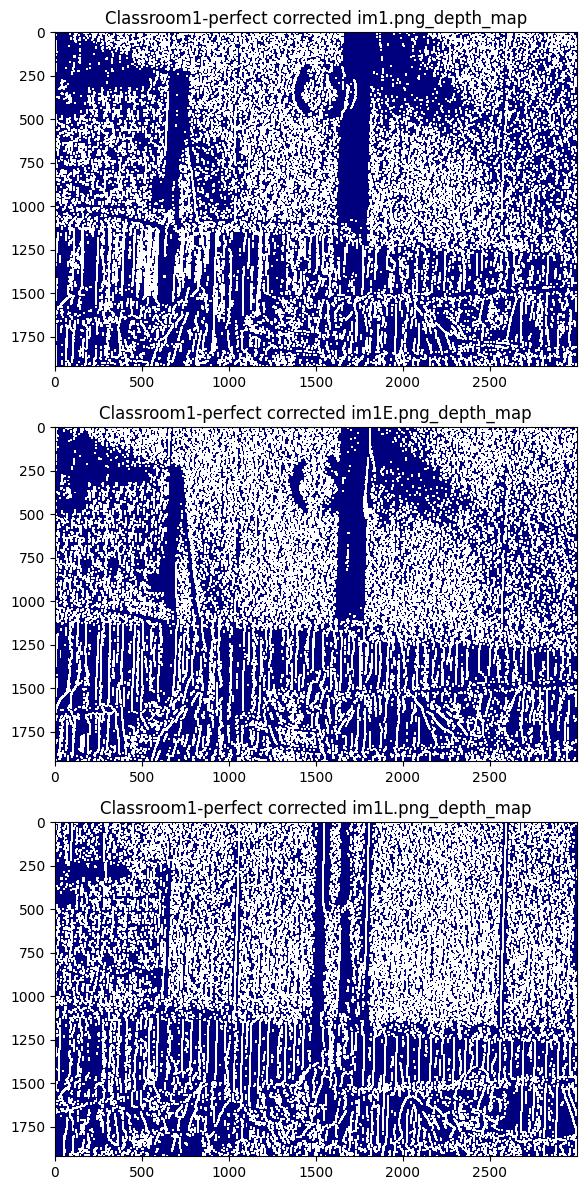

In [45]:
# plot corrected depth maps of Classroom1-perfect
depth_c_list = [i + '_depth_map' for i in images]

plt.figure(figsize=(10,12), layout="tight")
for j in range(len(depth_c_list)):
  plt.subplot(3, 1, j+1)
  plt.gca().set_title("{}".format(folders[1]+' corrected '+depth_c_list[j]))
  plt.imshow(depths_c[folders[1]][depth_c_list[j]], cmap='jet')
plt.show()